In [1]:
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

In [2]:
# Load the Oxford dataset
mat = scipy.io.loadmat(r"F:\Project\Oxford_Battery_Degradation_Dataset_1.mat")

In [3]:
# Print the names of the variables in the MAT file
print(mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'Cell1', 'Cell2', 'Cell3', 'Cell4', 'Cell5', 'Cell6', 'Cell7', 'Cell8'])


In [4]:
# Assuming mat is your loaded data
for cell_id in range(1, 9):  # Assuming you have 8 cells
    cell_name = "Cell{}".format(cell_id)
    cell_data = mat[cell_name][0, 0]

    print(f"{cell_name} (struct)")

    for cycle_name in cell_data.dtype.names:
        if cycle_name.startswith('cyc'):
            print(f"{cycle_name} (field)")

            for field_name in ['C1ch', 'C1dc', 'OCVch', 'OCVdc']:
                try:
                    field_data = cell_data[cycle_name][0, 0][field_name][0, 0]
                    print(f"{field_name} (field)")

                    # Get the names of files inside the field
                    file_names = field_data.dtype.names
                    for file_name in file_names:
                        print(f"{file_name} (field)")
                except KeyError:
                    pass  # Handle the case where the field may not exist for a particular cycle

Cell1 (struct)
cyc0000 (field)
C1ch (field)
t (field)
v (field)
q (field)
T (field)
C1dc (field)
t (field)
v (field)
q (field)
T (field)
OCVch (field)
t (field)
v (field)
q (field)
T (field)
OCVdc (field)
t (field)
v (field)
q (field)
T (field)
cyc0100 (field)
C1ch (field)
t (field)
v (field)
q (field)
T (field)
C1dc (field)
t (field)
v (field)
q (field)
T (field)
OCVch (field)
t (field)
v (field)
q (field)
T (field)
OCVdc (field)
t (field)
v (field)
q (field)
T (field)
cyc0200 (field)
C1ch (field)
t (field)
v (field)
q (field)
T (field)
C1dc (field)
t (field)
v (field)
q (field)
T (field)
OCVch (field)
t (field)
v (field)
q (field)
T (field)
OCVdc (field)
t (field)
v (field)
q (field)
T (field)
cyc0300 (field)
C1ch (field)
t (field)
v (field)
q (field)
T (field)
C1dc (field)
t (field)
v (field)
q (field)
T (field)
OCVch (field)
t (field)
v (field)
q (field)
T (field)
OCVdc (field)
t (field)
v (field)
q (field)
T (field)
cyc0400 (field)
C1ch (field)
t (field)
v (field)
q (field)
T (fie

In [5]:
# Extract and preprocess data for C1ch
input_data = []
CELL_SIZES = [83, 78, 82, 52, 51, 51, 82, 82]

for i, cell_size in enumerate(CELL_SIZES):
    cell_num = "Cell{}".format(i + 1)
    for j in range(int(cell_size)):
        cyc_num = "cyc{:04d}".format(j * 100)
        
        try:
            curr = mat[cell_num][0][cyc_num][0][0]["C1ch"][0][0]['q'][0][-1][0]
        except ValueError:
            curr = np.nan  # Set curr to NaN if value retrieval fails
        
        input_data.append([i + 1, j, curr])

# Create a DataFrame from the input data
df_input_ch = pd.DataFrame(input_data, columns=['cell', 'cycle', 'q_value_ch'])

In [6]:
# Increment cycle values by 100
df_input_ch['cycle'] = df_input_ch['cycle'] * 100

In [7]:
print(df_input_ch)

     cell  cycle  q_value_ch
0       1      0  724.120891
1       1    100  714.535043
2       1    200  709.854346
3       1    300  707.039349
4       1    400  702.234286
..    ...    ...         ...
556     8   7700  532.768358
557     8   7800  532.554724
558     8   7900  530.924624
559     8   8000  526.726858
560     8   8100  528.389313

[561 rows x 3 columns]


In [8]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_input_ch)

     cell  cycle  q_value_ch
0       1      0  724.120891
1       1    100  714.535043
2       1    200  709.854346
3       1    300  707.039349
4       1    400  702.234286
5       1    500  698.844001
6       1    600  695.485072
7       1    700  691.693226
8       1    800  687.630042
9       1    900  684.248807
10      1   1000  681.060727
11      1   1100  677.848634
12      1   1200  674.728189
13      1   1300  671.556081
14      1   1400  668.670979
15      1   1500         NaN
16      1   1600  662.972429
17      1   1700         NaN
18      1   1800  656.462189
19      1   1900  653.275160
20      1   2000  650.115742
21      1   2100  647.110512
22      1   2200  644.054944
23      1   2300  640.794875
24      1   2400  638.139137
25      1   2500  635.379087
26      1   2600  632.388785
27      1   2700  629.957217
28      1   2800  627.343985
29      1   2900  624.109562
30      1   3000  622.448909
31      1   3100  619.977835
32      1   3200  617.303179
33      1   33

In [9]:
# Linear interpolation for q_value_ch with missing values handled
df_input_ch['q_value_ch'] = df_input_ch.groupby('cell')['q_value_ch'].transform(lambda x: x.interpolate(method='linear', limit_area='inside'))

# Calculate state of health (soh_ch)
df_input_ch['soh_ch'] = df_input_ch['q_value_ch'] / 740

In [10]:
df_input_ch['Degradation'] = ((740 - df_input_ch['q_value_ch'] )/ 740)*100
df_input_ch['Battery_Health'] = 100 - df_input_ch['Degradation']

In [11]:
print(df_input_ch)

     cell  cycle  q_value_ch    soh_ch  Degradation  Battery_Health
0       1      0  724.120891  0.978542     2.145825       97.854175
1       1    100  714.535043  0.965588     3.441210       96.558790
2       1    200  709.854346  0.959263     4.073737       95.926263
3       1    300  707.039349  0.955459     4.454142       95.545858
4       1    400  702.234286  0.948965     5.103475       94.896525
..    ...    ...         ...       ...          ...             ...
556     8   7700  532.768358  0.719957    28.004276       71.995724
557     8   7800  532.554724  0.719669    28.033145       71.966855
558     8   7900  530.924624  0.717466    28.253429       71.746571
559     8   8000  526.726858  0.711793    28.820695       71.179305
560     8   8100  528.389313  0.714040    28.596039       71.403961

[561 rows x 6 columns]


In [12]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_input_ch)

     cell  cycle  q_value_ch    soh_ch  Degradation  Battery_Health
0       1      0  724.120891  0.978542     2.145825       97.854175
1       1    100  714.535043  0.965588     3.441210       96.558790
2       1    200  709.854346  0.959263     4.073737       95.926263
3       1    300  707.039349  0.955459     4.454142       95.545858
4       1    400  702.234286  0.948965     5.103475       94.896525
5       1    500  698.844001  0.944384     5.561621       94.438379
6       1    600  695.485072  0.939845     6.015531       93.984469
7       1    700  691.693226  0.934721     6.527942       93.472058
8       1    800  687.630042  0.929230     7.077021       92.922979
9       1    900  684.248807  0.924661     7.533945       92.466055
10      1   1000  681.060727  0.920352     7.964767       92.035233
11      1   1100  677.848634  0.916012     8.398833       91.601167
12      1   1200  674.728189  0.911795     8.820515       91.179485
13      1   1300  671.556081  0.907508     9.249

In [13]:
# Define the list of cells you want to include
selected_cells = [1, 2, 3, 4, 5, 6, 7, 8]

# Define the cycle values of interest
cycle_values_of_interest = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000]

# Initialize an empty list to store the extracted values
extracted_values = []

# Extract values for each cell and cycle value
for cell_num in selected_cells:
    for cycle_value in cycle_values_of_interest:
        # Filter the DataFrame for the selected cell and cycle value
        filtered_data = df_input_ch[(df_input_ch['cell'] == cell_num) & (df_input_ch['cycle'] == cycle_value)]
        
        # If there's data for the given cell and cycle value, extract the values
        if not filtered_data.empty:
            # Extract the desired values, for example 'q_value_ch'
            extracted_value = filtered_data['q_value_ch'].iloc[0]  # Assuming q_value_ch is the column of interest
            
            # Append the extracted value along with cell and cycle information to the list
            extracted_values.append({'cell': cell_num, 'cycle': cycle_value, 'q_value_ch': extracted_value})

# Create a new DataFrame from the extracted values
new_df = pd.DataFrame(extracted_values)

# Display the new DataFrame
print(new_df)

    cell  cycle  q_value_ch
0      1      0  724.120891
1      1   1000  681.060727
2      1   2000  650.115742
3      1   3000  622.448909
4      1   4000  600.907560
..   ...    ...         ...
57     8   4000  606.853119
58     8   5000  583.118742
59     8   6000  561.604140
60     8   7000  544.456606
61     8   8000  526.726858

[62 rows x 3 columns]


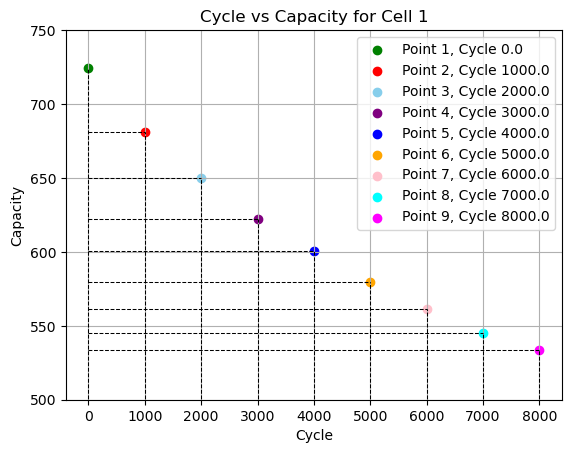

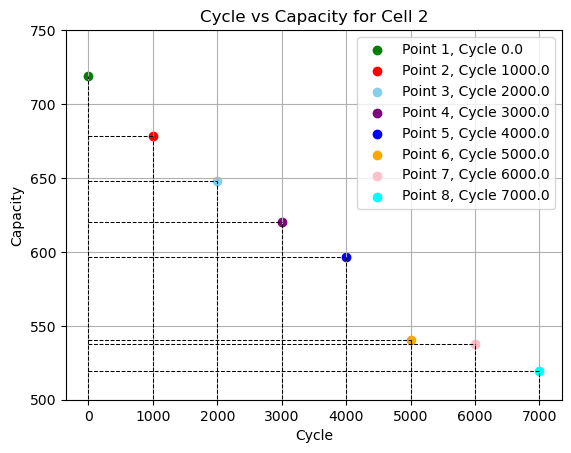

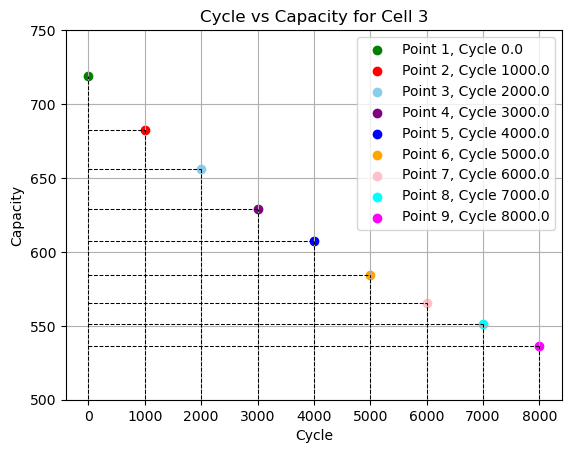

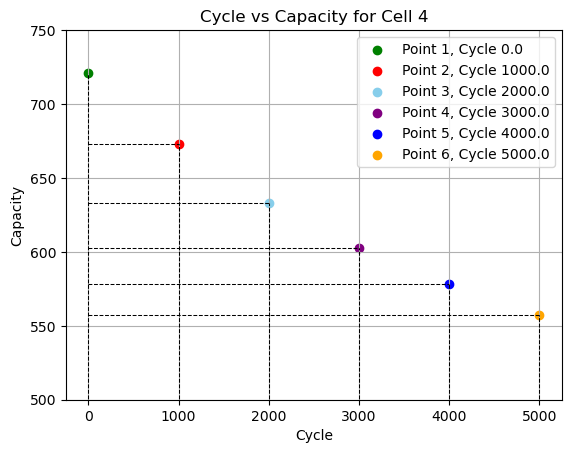

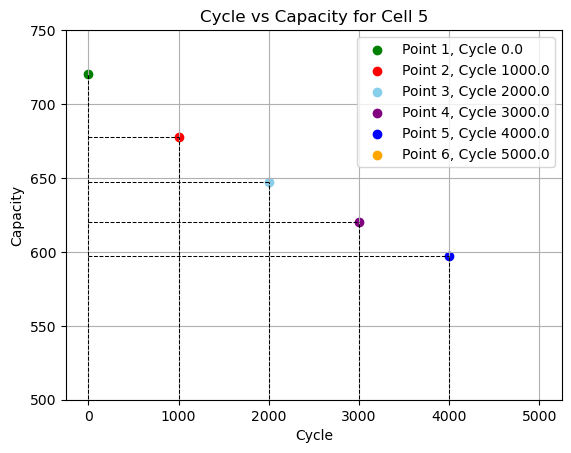

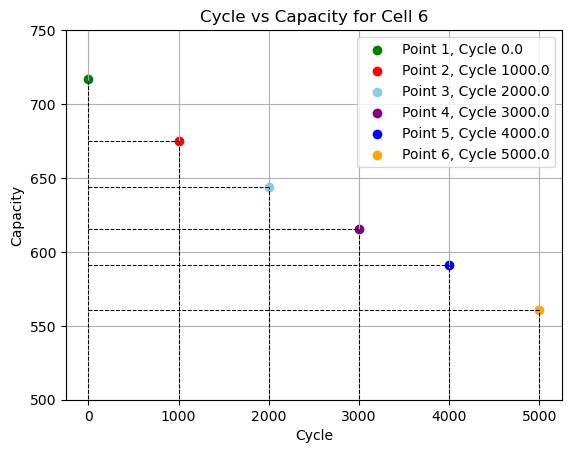

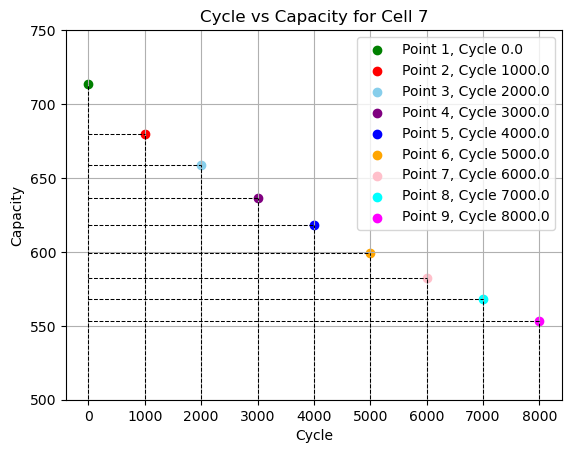

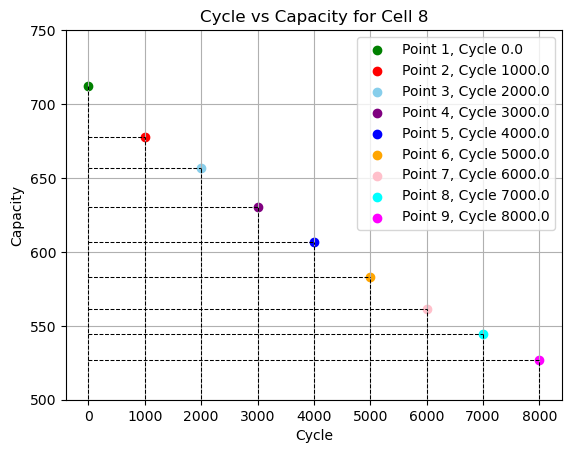

In [14]:
import matplotlib.pyplot as plt

# Define the list of cells you want to include
selected_cells = [1, 2, 3, 4, 5, 6, 7, 8]

# Define the colors for the nine points
colors = ['green', 'red', 'skyblue', 'purple', 'blue', 'orange', 'pink', 'cyan', 'magenta']

# Plotting scatter plot for each selected cell
for cell_num in selected_cells:
    # Filter the DataFrame for the selected cell and get the first five points
    cell_data = new_df[new_df['cell'] == cell_num]
    
    # Create a new plot for each cell
    plt.figure()
    for i, (_, row) in enumerate(cell_data.iterrows()):
        plt.scatter(row['cycle'], row['q_value_ch'], color=colors[i], label=f'Point {i+1}, Cycle {row["cycle"]}')
        plt.plot([row['cycle'], row['cycle']], [0, row['q_value_ch']], color='black', linestyle='--', linewidth=0.75)
        plt.plot([0, row['cycle']], [row['q_value_ch'], row['q_value_ch']], color='black', linestyle='--', linewidth=0.75)

    plt.xlabel('Cycle')
    plt.ylabel('Capacity')
    # Set y-axis limits
    plt.ylim(500,750)
    plt.title(f'Cycle vs Capacity for Cell {cell_num}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [15]:
# IMPORTING THE NECESSARY PACKAGES

In [16]:
from tensorflow.keras.layers import Bidirectional, GRU, Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

In [17]:
# USING THE MAPE ERROR calculation FORMULA GIVE IN THE BASE PAPER
def calculate_mape(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    
    n = len(y_true)  # Number of data points
    mape_sum = 0.0
    
    for i in range(n):
        mape_sum += abs((y_pred[i] - y_true[i]) / y_true[i])
    
    mape = (100 / n) * mape_sum
    
    return mape.item()  # Convert the numpy array to a scalar and return

In [18]:
# Separate data for training and testing
train_cells = [1, 2, 3, 4, 5, 6]
test_cells = [7, 8]

In [19]:
# Initialize lists to store training and testing data
X_train_all = []
y_train_all = []
X_test_all = []
y_test_all = []

In [20]:
# Extract data for training set
for cell_id in train_cells:
    df_cell = df_input_ch[df_input_ch['cell'] == cell_id]
    X_train_cell = df_cell[['cycle', 'q_value_ch', 'Degradation']].values
    y_train_cell = df_cell['Battery_Health'].values
    X_train_all.append(X_train_cell)
    y_train_all.append(y_train_cell)

In [21]:
# Extract data for testing set
for cell_id in test_cells:
    df_cell = df_input_ch[df_input_ch['cell'] == cell_id]
    X_test_cell = df_cell[['cycle', 'q_value_ch', 'Degradation']].values
    y_test_cell = df_cell['Battery_Health'].values
    X_test_all.append(X_test_cell)
    y_test_all.append(y_test_cell)

In [22]:
# Concatenate data from all cells
X_train = np.concatenate(X_train_all, axis=0)
y_train = np.concatenate(y_train_all, axis=0)
X_test = np.concatenate(X_test_all, axis=0)
y_test = np.concatenate(y_test_all, axis=0)

In [23]:
# Reshape X to fit in the GRU
X_train = X_train.reshape(-1, X_train.shape[1], 1)
X_test = X_test.reshape(-1, X_test.shape[1], 1)

In [24]:
# Define custom learning rate
learning_rate = 0.001

# Building the model
model = Sequential()
model.add(Bidirectional(GRU(512, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Bidirectional(GRU(256, return_sequences=False)))
model.add(Dense(128, activation='relu')) 
model.add(Dense(1, activation='linear'))
adam_optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=adam_optimizer, loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=500, batch_size=52, verbose=1, validation_data=(X_test, y_test))

Epoch 1/500
8/8 [==============================] - 10s 291ms/step - loss: 5197.0190 - mae: 71.3141 - val_loss: 3486.4543 - val_mae: 58.6626
Epoch 2/500
8/8 [==============================] - 1s 89ms/step - loss: 2656.8242 - mae: 50.7644 - val_loss: 1571.2095 - val_mae: 39.0716
Epoch 3/500
8/8 [==============================] - 1s 85ms/step - loss: 997.1961 - mae: 30.0663 - val_loss: 340.1534 - val_mae: 17.1926
Epoch 4/500
8/8 [==============================] - 1s 69ms/step - loss: 160.8611 - mae: 10.4305 - val_loss: 47.8346 - val_mae: 5.9736
Epoch 5/500
8/8 [==============================] - 1s 92ms/step - loss: 100.0621 - mae: 8.2384 - val_loss: 138.0491 - val_mae: 9.9327
Epoch 6/500
8/8 [==============================] - 1s 80ms/step - loss: 130.2165 - mae: 9.4813 - val_loss: 82.4184 - val_mae: 7.5480
Epoch 7/500
8/8 [==============================] - 1s 76ms/step - loss: 67.5421 - mae: 6.8511 - val_loss: 44.8997 - val_mae: 5.7974
Epoch 8/500
8/8 [==============================] - 1s

In [25]:
# Evaluate the model on the test set
loss, mae = model.evaluate(X_test, y_test)

# Compute metrics
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = calculate_mape(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE for Test Set: {rmse}")
print(f"R2 score for Test Set: {r2}")
print(f"MAPE for Test Set: {mape}")
print(f"MAE for Test Set: {mae}")

6/6 [==============================] - 5s 31ms/step
RMSE for Test Set: 0.28262162731142554
R2 score for Test Set: 0.9982111817916486
MAPE for Test Set: 0.29363641142845154
MAE for Test Set: 0.23855376138055956


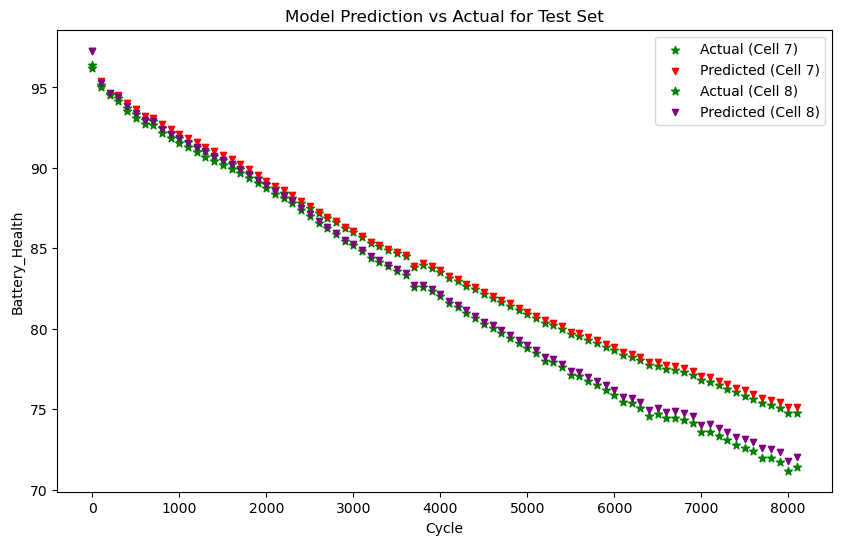

In [26]:
# Visualize the results
plt.figure(figsize=(10, 6))
plt.scatter(X_test[:len(y_test_all[0]), 0], y_test_all[0], label='Actual (Cell 7)', color='green', marker='*', s=35)
plt.scatter(X_test[:len(y_test_all[0]), 0], y_pred[:len(y_test_all[0])], label='Predicted (Cell 7)', color='red', marker='v', s=20)
plt.scatter(X_test[len(y_test_all[0]):, 0], y_test_all[1], label='Actual (Cell 8)', color='green', marker='*', s=35)
plt.scatter(X_test[len(y_test_all[0]):, 0], y_pred[len(y_test_all[0]):], label='Predicted (Cell 8)', color='purple', marker='v', s=20)
plt.xlabel('Cycle')
plt.ylabel('Battery_Health')
plt.title('Model Prediction vs Actual for Test Set')
plt.legend()
plt.show()

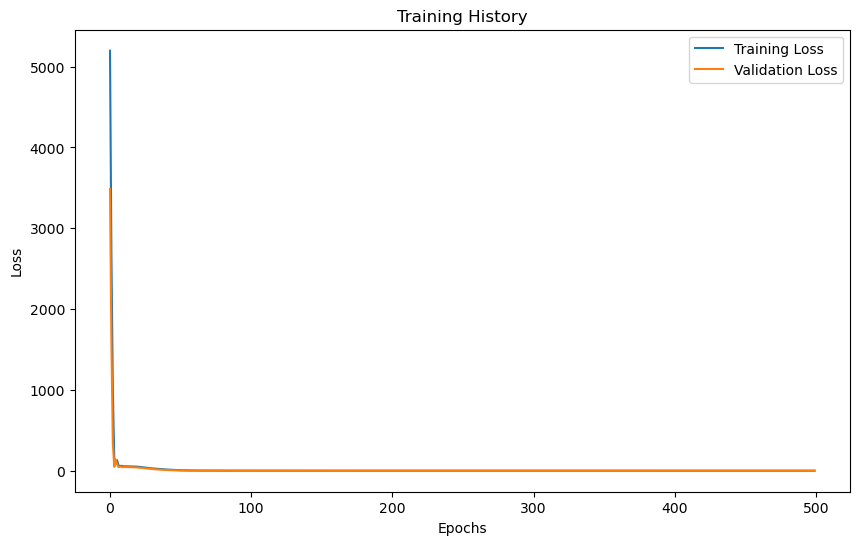

In [27]:
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.show()